In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
import h5py
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [2]:
# initialize constants
c = 0.299792458 #speed of light [um/fs]
# set pure spectral properties
lambda_0 = 0.8  # central wavelength [um]
tau_0 = 15  # FL pulse duration [fs] 1/e2 intensity half-width (same def as beam waist)
# frequency properties
omega_0 = 2*np.pi*c/lambda_0
delta_omega = 2/tau_0
# set beam waist
w_0 = 4
# calculate Rayleigh range
z_R = (omega_0*w_0**2)/(2*c)
# perturbation parameter
eps = w_0/z_R

In [3]:
GDD = np.array([-15000, -5000, -2000, -1000, 0, +1000, +2000, +5000])  # Group Delay Dispersion fs^2
tau_p = 60.0  # radial group delay fs

v_exp = 1/(1+(c*GDD)/(z_R*tau_p))
print(v_exp)

t_start = -200*tau_0
t_end = 200*tau_0
n = 10
num_t = np.int_(np.round(n*(t_end-t_start)/(lambda_0/c)))
omega = np.linspace(1,n*omega_0,num_t)
omega_step = omega[1]-omega[0]
time = np.fft.fftshift(np.fft.fftfreq(num_t,omega_step/(2*np.pi)))
dt = time[1]-time[0]

z = np.linspace(-15*z_R, +15*z_R, 400)

temp = xr.DataArray(np.zeros([len(z), len(omega), len(GDD)]),
                   coords=[z, omega, GDD],
                   dims=['z', 'omega', 'GDD'])

pulse_env = np.exp(-((temp.coords['omega']-omega_0)/delta_omega)**2)
z_omega = z_R*tau_p*(temp.coords['omega']-omega_0)

w = w_0*np.sqrt(1+((temp.coords['z']-z_omega)/z_R)**2)
phi_norm = -temp.coords['omega']*temp.coords['z']/c
phi_spec = -(temp.coords['GDD']/2)*(temp.coords['omega']-omega_0)**2
phi_G = np.arctan((temp.coords['z']-z_omega)/z_R)

c_2 = (w_0/w)**2 * np.exp(1j*(phi_norm + phi_spec + 2*phi_G))

E_z_spec = pulse_env*c_2*eps**2
E_z_spec = E_z_spec.transpose('z', 'omega', 'GDD')
E_z_time = np.fft.fftshift(np.fft.ifft(E_z_spec, norm='ortho', axis=1), axes=1)
E_z_time = xr.DataArray(E_z_time,
                        coords=[z, time, GDD],
                        dims=['z', 'time', 'GDD'])

norm = (np.abs(E_z_time)).sel(GDD=0, method='nearest').max().values
E_z_time = E_z_time/norm

[-5.1857459   1.6600599   1.18912404  1.08639257  1.          0.92633556
  0.86277939  0.71550611]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


Text(0, 0.5, '$v_{ff}/c$')

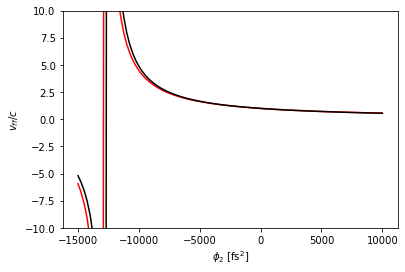

In [4]:
tau_p = 60.0  # radial group delay fs
GDD1 = np.linspace(-15000, 10000, 101)  # Group Delay Dispersion fs^2

v_exp = 1/(1+(c*GDD1)/(z_R*tau_p))

speed = np.zeros(len(GDD1))

t_start = -200*tau_0
t_end = 200*tau_0
n = 10
num_t = np.int_(np.round(n*(t_end-t_start)/(lambda_0/c)))
omega = np.linspace(1,n*omega_0,num_t)
omega_step = omega[1]-omega[0]
time = np.fft.fftshift(np.fft.fftfreq(num_t,omega_step/(2*np.pi)))
dt = time[1]-time[0]

for j in range(len(GDD1)):

    z = np.linspace(-3*z_R, +3*z_R, 100)

    temp = xr.DataArray(np.zeros([len(z), len(omega)]),
                       coords=[z, omega],
                       dims=['z', 'omega'])

    pulse_env = np.exp(-((temp.coords['omega']-omega_0)/delta_omega)**2)
    z_omega = z_R*tau_p*(temp.coords['omega']-omega_0)

    w = w_0*np.sqrt(1+((temp.coords['z']-z_omega)/z_R)**2)
    phi_norm = -temp.coords['omega']*temp.coords['z']/c
    phi_spec = -(GDD1[j]/2)*(temp.coords['omega']-omega_0)**2
    phi_G = np.arctan((temp.coords['z']-z_omega)/z_R)

    c_2 = (w_0/w)**2 * np.exp(1j*(phi_norm + phi_spec + 2*phi_G))

    E_z_spec = pulse_env*c_2*eps**2
    E_z_spec = E_z_spec.transpose('z', 'omega')
    E_z_test = np.fft.fftshift(np.fft.ifft(E_z_spec, norm='ortho', axis=1), axes=1)
    E_z_test = xr.DataArray(E_z_test,
                            coords=[z, time],
                            dims=['z', 'time'])

    peak_pos_time = time[(np.abs(E_z_test)**2).argmax('time')]
    p = np.polyfit(peak_pos_time, z, 1)
    speed[j] = p[0]/c
    print(str(j))
        
plt.plot(GDD1, speed, color='r')
plt.plot(GDD1, v_exp, color='k')
#plt.xlim(-7500, 2500)
plt.ylim(-10, 10)
plt.xlabel(r'$\phi_2$ [fs$^2$]')
plt.ylabel(r'$v_{ff}/c$')

Text(0, 0.5, '$E_z/E_z^{max}$')

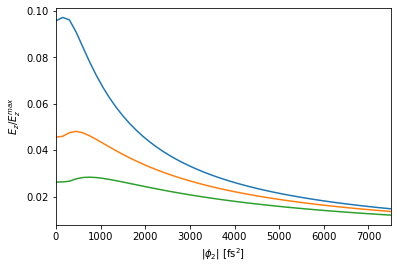

In [5]:
tau_p = np.array([0.0, 30.0, 45.0, 60.0])  # radial group delay fs
GDD = np.linspace(0, 7500, 51)  # Group Delay Dispersion fs^2

intensity = np.zeros((len(tau_p), len(GDD)))

t_start = -100*tau_0
t_end = 100*tau_0
n = 10
num_t = np.int_(np.round(n*(t_end-t_start)/(lambda_0/c)))
omega = np.linspace(1,n*omega_0,num_t)
omega_step = omega[1]-omega[0]
time = np.fft.fftshift(np.fft.fftfreq(num_t,omega_step/(2*np.pi)))
dt = time[1]-time[0]

for i in range(len(tau_p)):
    for j in range(len(GDD)):

        z = np.linspace(-2*z_R, +2*z_R, 20)

        temp = xr.DataArray(np.zeros([len(z), len(omega)]),
                           coords=[z, omega],
                           dims=['z', 'omega'])

        pulse_env = np.exp(-((temp.coords['omega']-omega_0)/delta_omega)**2)
        z_omega = z_R*tau_p[i]*(temp.coords['omega']-omega_0)

        w = w_0*np.sqrt(1+((temp.coords['z']-z_omega)/z_R)**2)
        phi_norm = -temp.coords['omega']*temp.coords['z']/c
        phi_spec = -(GDD[j]/2)*(temp.coords['omega']-omega_0)**2
        phi_G = np.arctan((temp.coords['z']-z_omega)/z_R)

        c_2 = (w_0/w)**2 * np.exp(1j*(phi_norm + phi_spec + 2*phi_G))

        E_z_spec = pulse_env*c_2*eps**2
        E_z_spec = E_z_spec.transpose('z', 'omega')
        E_z_test = np.fft.fftshift(np.fft.ifft(E_z_spec, norm='ortho', axis=1), axes=1)
        E_z_test = xr.DataArray(E_z_test,
                                coords=[z, time],
                                dims=['z', 'time'])

        intensity[i, j] = (np.abs(E_z_test)**2).max().values
        #print(str(i)+', '+str(j))
        
plt.plot(GDD, intensity[1, :]/np.max(intensity[0, :]))
plt.plot(GDD, intensity[2, :]/np.max(intensity[0, :]))
plt.plot(GDD, intensity[3, :]/np.max(intensity[0, :]))
plt.xlim(0, 7500)
plt.xlabel(r'$|\phi_2|$ [fs$^2$]')
plt.ylabel(r'$E_z/E_z^{max}$')

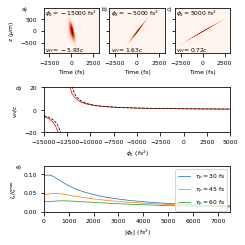

In [6]:
# Define figure dimensions
fig_width = 8.6/2.54  # width in inches
fig_height = 8.6/2.54       # height in inches
fig_size = [fig_width,fig_height]
# tell matplotlib to use latex font rendering
plt.rc('text', usetex=False)
# adjust fontsize
plt.rcParams.update({'font.size' : 6,
          'axes.labelsize' : 6,
          'legend.fontsize': 6,
          'xtick.labelsize' : 6,
          'ytick.labelsize' : 6,
          'lines.linewidth'   : 0.75,
          'lines.markersize'   : 2})
# adjust resolution
plt.rcParams['savefig.dpi'] = 600

fig=plt.figure(figsize=fig_size)

ax1 = plt.subplot(3, 3, 1)
(np.abs(E_z_time)**2).sel(GDD=-15000, method='nearest').plot(cmap='Reds', add_colorbar=False)
#plt.plot(time, v_exp[0]*c*time, color='b', ls='--')
#plt.plot(time, c*time, color='w', ls='--')
plt.xlabel('Time (fs)')
plt.ylabel(r'z ($\mu$m)')

ax2 = plt.subplot(3, 3, 2)
(np.abs(E_z_time)**2).sel(GDD=-5000, method='nearest').plot(cmap='Reds', add_colorbar=False)
#plt.plot(time, v_exp[6]*c*time, color='b', ls='--')
#plt.plot(time, c*time, color='w', ls='--')
plt.xlabel('Time (fs)')
plt.ylabel(r'z ($\mu$m)')

ax3 = plt.subplot(3, 3, 3)
(np.abs(E_z_time)**2).sel(GDD=+5000, method='nearest').plot(cmap='Reds', add_colorbar=False)
#plt.plot(time, v_exp[6]*c*time, color='b', ls='--')
#plt.plot(time, c*time, color='w', ls='--')
plt.xlabel('Time (fs)')
plt.ylabel(r'z ($\mu$m)')

ax5 = plt.subplot(3, 1, 2)
plt.plot(GDD1[0:9], speed[0:9], color='r')
plt.plot(GDD1[9:], speed[9:], color='r')
plt.plot(GDD1[0:10], v_exp[0:10], color='k', ls='--')
plt.plot(GDD1[10:], v_exp[10:], color='k', ls='--')
plt.xlim(-15000, 5000)
plt.ylim(-20, 20)
plt.xlabel(r'$\phi_2$ (fs$^2$)')
plt.ylabel(r'$v_{ff}/c$')

ax6 = plt.subplot(3, 1, 3)
plt.plot(GDD, intensity[1, :]/np.max(intensity[0, :]))
plt.plot(GDD, intensity[2, :]/np.max(intensity[0, :]))
plt.plot(GDD, intensity[3, :]/np.max(intensity[0, :]))
#ax6.yaxis.tick_right()
plt.xlim(0, 7500)
plt.ylim(0, 0.12)
plt.xlabel(r'$|\phi_2|$ (fs$^2$)')
plt.ylabel(r'$I_z/I_z^{max}$')
#ax6.yaxis.set_label_position('right')
plt.legend([r'$\tau_p = 30$ fs', r'$\tau_p = 45$ fs', r'$\tau_p = 60$ fs'], loc=1)

ax1.set_title('')
ax2.set_title('')
ax3.set_title('')

ax2.set_yticklabels([])
ax3.set_yticklabels([])

ax2.set_ylabel('')
ax3.set_ylabel('')

ax1.text(-0.4, 0.95, 'a)', transform=ax1.transAxes)
ax2.text(-0.15, 0.95, 'b)', transform=ax2.transAxes)
ax3.text(-0.15, 0.95, 'c)', transform=ax3.transAxes)
ax5.text(-0.15, 0.95, 'd)', transform=ax5.transAxes)
ax6.text(-0.15, 0.95, 'e)', transform=ax6.transAxes)

#ax1.text(0.02, 0.92, r'$\tau_p = 60$ fs', transform=ax1.transAxes)
#ax2.text(0.02, 0.92, r'$\tau_p = 60$ fs', transform=ax2.transAxes)
#ax3.text(0.02, 0.92, r'$\tau_p = 60$ fs', transform=ax3.transAxes)

ax1.text(0.02, 0.85, r'$\phi_2 = -15000$ fs$^2$', transform=ax1.transAxes)
ax2.text(0.02, 0.85, r'$\phi_2 = -5000$ fs$^2$', transform=ax2.transAxes)
ax3.text(0.02, 0.85, r'$\phi_2 = 5000$ fs$^2$', transform=ax3.transAxes)

ax1.text(0.02, 0.05, r'$v_{ff} = -5.93c$', transform=ax1.transAxes)
ax2.text(0.02, 0.05, r'$v_{ff} = 1.63c$', transform=ax2.transAxes)
ax3.text(0.02, 0.05, r'$v_{ff} = 0.72c$', transform=ax3.transAxes)

plt.tight_layout(w_pad=0)

plt.savefig('report/figures/LC_FF.png')